In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('blood/')]
groups = ['Histone', 'TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'blood/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/24 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

result_dict = defaultdict(set)
with open("blood.bed", "r") as bed_file:
    for line in bed_file:
        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [5]:
from tqdm import tqdm
win_in = []
win_out = []
width = 50000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:47<00:00,  1.88s/it]


In [6]:
win_in[:10]

[['chr1', 158924889, 158974889],
 ['chr1', 119158107, 119208107],
 ['chr1', 47297116, 47347116],
 ['chr1', 203766621, 203816621],
 ['chr1', 223355230, 223405230],
 ['chr1', 167538783, 167588783],
 ['chr1', 148249184, 148299184],
 ['chr1', 242926687, 242976687],
 ['chr1', 9036386, 9086386],
 ['chr1', 72148322, 72198322]]

In [7]:
win_out[:10]

[['chr1', 157924889, 157974889],
 ['chr1', 157424889, 157474889],
 ['chr1', 157174889, 157224889],
 ['chr1', 157424889, 157474889],
 ['chr1', 157924889, 157974889],
 ['chr1', 158924889, 158974889],
 ['chr1', 118158107, 118208107],
 ['chr1', 117658107, 117708107],
 ['chr1', 117408107, 117458107],
 ['chr1', 117658107, 117708107]]

In [8]:
print(len(win_in), len(win_out))

1761 10367


In [9]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in)*2, replace=False)]


In [10]:
print(len(ints_in1), len(ints_out1))

1761 3522


In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chrX', '84161878', '84211878', '1'],
       ['chr13', '63601761', '63651761', '0'],
       ['chr11', '100050326', '100100326', '0'],
       ['chr4', '163048552', '163098552', '1'],
       ['chr13', '39523161', '39573161', '1'],
       ['chr12', '23861961', '23911961', '1'],
       ['chr11', '59830146', '59880146', '0'],
       ['chr15', '92268156', '92318156', '0'],
       ['chr1', '149421407', '149471407', '0'],
       ['chr14', '20274355', '20324355', '1']], dtype='<U21')

In [12]:
import numpy as np
import torch
from tqdm import tqdm 
from sklearn.preprocessing import StandardScaler


X = []
y = []


pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row)
        y.append(target)
    else:
        continue 

pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5283/5283 [00:15<00:00, 336.33it/s]


In [13]:
X = np.array(X)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)


X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [14]:
X = np.array(X)
X

array([[-0.05410573, -0.09744704, -0.07082916, ..., -0.23338944,
        -0.42916808,  0.38738894],
       [-0.05410573, -0.09744704, -0.07082916, ..., -0.23338944,
        -0.8405741 , -1.3181412 ],
       [-0.05410573, -0.09744704, -0.07082916, ..., -0.23338944,
        -0.84838986, -1.5496061 ],
       ...,
       [-0.05410573, -0.09744704, -0.07082916, ..., -0.23338944,
        -0.55319697, -0.18432114],
       [-0.05410573, -0.09744704, -0.07082916, ..., -0.23338944,
        -1.1752188 ,  0.6974828 ],
       [-0.05410573,  0.7700679 ,  0.3697441 , ...,  0.2425185 ,
         0.1316716 , -1.0055311 ]], dtype=float32)

In [15]:
X.shape

(5283, 24)

In [16]:
y

tensor([1, 0, 0,  ..., 0, 0, 0])

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)


X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


2023-05-16 15:33:03.806904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 15:33:04.465389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 0.6449 - accuracy: 0.6571 - val_loss: 0.6353 - val_accuracy: 0.6651
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6671 - val_loss: 0.6354 - val_accuracy: 0.6651
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6363 - accuracy: 0.6671 - val_loss: 0.6343 - val_accuracy: 0.6651
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6352 - accuracy: 0.6671 - val_loss: 0.6353 - val_accuracy: 0.6651
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6352 - accuracy: 0.6671 - val_loss: 0.6347 - val_accuracy: 0.6651
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6355 - accuracy: 0.6671 - val_loss: 0.6347 - val_accuracy: 0.6651
Epoch 7/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6350 - accuracy: 0.6671 - val_loss: 0.6347 - val_accuracy: 0.6651
Epoch 

In [21]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [22]:
X = X_copy
y = y_copy

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_2490/3757297636.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_2490/3757297636.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6421, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6344, Test F1-score: 0.5335, Test ROC-AUC: 0.5458, Test PR-AUC: 0.3976


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [2/20], Train Loss: 0.6343, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6320, Test F1-score: 0.5395, Test ROC-AUC: 0.5441, Test PR-AUC: 0.3956
Epoch [3/20], Train Loss: 0.6348, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6312, Test F1-score: 0.5454, Test ROC-AUC: 0.5514, Test PR-AUC: 0.4012
Epoch [4/20], Train Loss: 0.6342, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6304, Test F1-score: 0.5454, Test ROC-AUC: 0.5591, Test PR-AUC: 0.3996
Epoch [5/20], Train Loss: 0.6317, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6311, Test F1-score: 0.5603, Test ROC-AUC: 0.5515, Test PR-AUC: 0.3992
Epoch [6/20], Train Loss: 0.6306, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6321, Test F1-score: 0.5400, Test ROC-AUC: 0.5449, Test PR-AUC: 0.3989
Epoch [7/20], Train Loss: 0.6296, Train F1-score: 0.3333, Train R

/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [8/20], Train Loss: 0.6280, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6306, Test F1-score: 0.5598, Test ROC-AUC: 0.5571, Test PR-AUC: 0.4069
Epoch [9/20], Train Loss: 0.6276, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6329, Test F1-score: 0.5691, Test ROC-AUC: 0.5497, Test PR-AUC: 0.4040


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [10/20], Train Loss: 0.6259, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6323, Test F1-score: 0.5666, Test ROC-AUC: 0.5565, Test PR-AUC: 0.4076


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [11/20], Train Loss: 0.6245, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6307, Test F1-score: 0.5757, Test ROC-AUC: 0.5589, Test PR-AUC: 0.4153
Epoch [12/20], Train Loss: 0.6241, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6364, Test F1-score: 0.5717, Test ROC-AUC: 0.5602, Test PR-AUC: 0.4103


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [13/20], Train Loss: 0.6227, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6343, Test F1-score: 0.5865, Test ROC-AUC: 0.5617, Test PR-AUC: 0.4119
Epoch [14/20], Train Loss: 0.6228, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6415, Test F1-score: 0.5666, Test ROC-AUC: 0.5516, Test PR-AUC: 0.3974


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [15/20], Train Loss: 0.6197, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6456, Test F1-score: 0.5688, Test ROC-AUC: 0.5569, Test PR-AUC: 0.3945
Epoch [16/20], Train Loss: 0.6204, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6459, Test F1-score: 0.5729, Test ROC-AUC: 0.5516, Test PR-AUC: 0.3923


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [17/20], Train Loss: 0.6186, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6462, Test F1-score: 0.5768, Test ROC-AUC: 0.5612, Test PR-AUC: 0.3961


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [18/20], Train Loss: 0.6162, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6492, Test F1-score: 0.5730, Test ROC-AUC: 0.5604, Test PR-AUC: 0.3923


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [19/20], Train Loss: 0.6158, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6552, Test F1-score: 0.5666, Test ROC-AUC: 0.5649, Test PR-AUC: 0.3993
Epoch [20/20], Train Loss: 0.6164, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6562, Test F1-score: 0.5596, Test ROC-AUC: 0.5619, Test PR-AUC: 0.3930


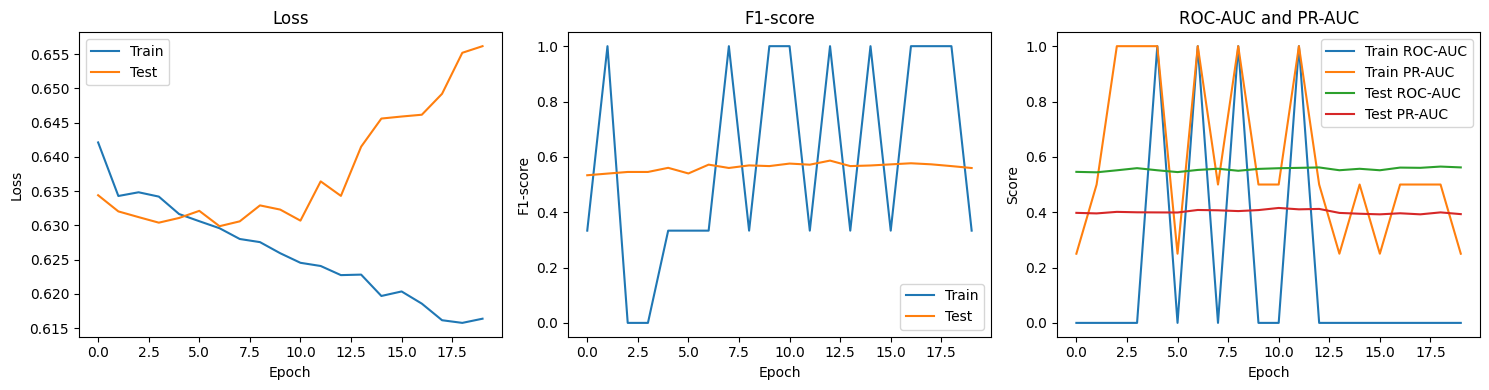

In [25]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1) 

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_2490/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_2490/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6857, Train F1-score: 0.5467, Train ROC-AUC: 0.4919, Train PR-AUC: 0.3228, Test Loss: 0.6789, Test F1-score: 0.5335, Test ROC-AUC: 0.5077, Test PR-AUC: 0.3722
Epoch [2/20], Train Loss: 0.6716, Train F1-score: 0.5339, Train ROC-AUC: 0.5153, Train PR-AUC: 0.3462, Test Loss: 0.6651, Test F1-score: 0.5335, Test ROC-AUC: 0.5214, Test PR-AUC: 0.3831
Epoch [3/20], Train Loss: 0.6589, Train F1-score: 0.5349, Train ROC-AUC: 0.5106, Train PR-AUC: 0.3508, Test Loss: 0.6504, Test F1-score: 0.5357, Test ROC-AUC: 0.5200, Test PR-AUC: 0.3822
Epoch [4/20], Train Loss: 0.6475, Train F1-score: 0.5345, Train ROC-AUC: 0.5234, Train PR-AUC: 0.3529, Test Loss: 0.6402, Test F1-score: 0.5357, Test ROC-AUC: 0.5216, Test PR-AUC: 0.3837
Epoch [5/20], Train Loss: 0.6409, Train F1-score: 0.5336, Train ROC-AUC: 0.5052, Train PR-AUC: 0.3430, Test Loss: 0.6356, Test F1-score: 0.5357, Test ROC-AUC: 0.5237, Test PR-AUC: 0.3898
Epoch [6/20], Train Loss: 0.6330, Train F1-score: 0.5336, Train R

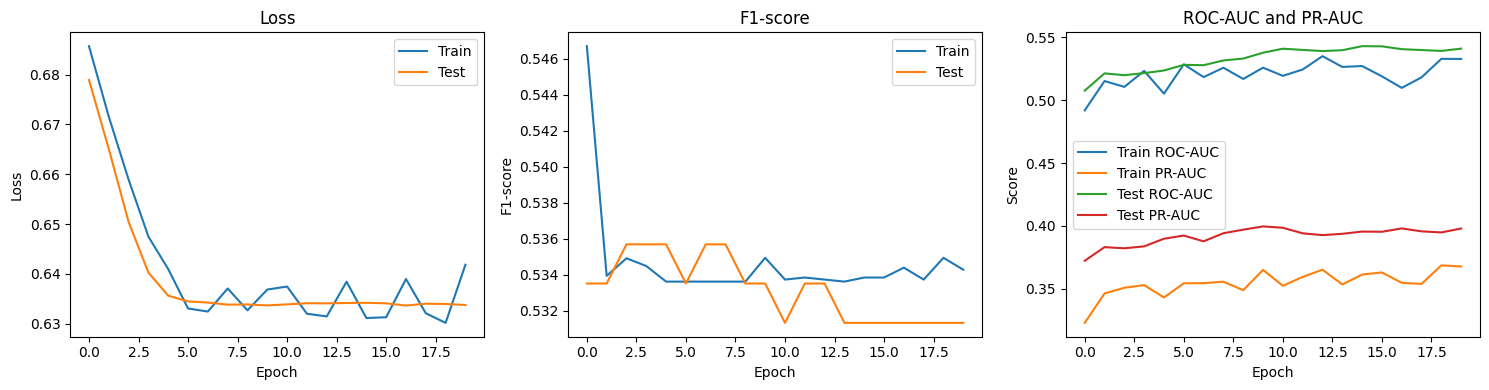

In [27]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature Histone_H3K23ac importance: 0.0009460737937558861
Feature Histone_CENPA importance: 0.0
Feature Histone_H1.2 importance: 0.0
Feature Histone_H1.5 importance: 0.0
Feature Histone_H2AK119Ub importance: 0.0
Feature Histone_H2AK120Ub importance: 0.0
Feature Histone_H2A.X importance: 0.0
Feature Histone_H2A.XS139ph importance: 0.0
Feature Histone_H2A.Zac importance: 0.0
Feature Histone_H2A.Z importance: 0.0
Feature Histone_H2BK20ac importance: 0.0
Feature Histone_H2Bub importance: 0.0
Feature Histone_H2 importance: 0.0
Feature Histone_H3.3 importance: 0.0
Feature Histone_H3K122ac importance: 0.0
Feature Histone_H3K14cr importance: 0.0
Feature Histone_H3K18ac importance: 0.0
Feature Histone_H3K27me1 importance: 0.0
Feature Histone_H3K27me2 importance: 0.0
Feature Histone_H3K28ac importance: 0.0
Feature Histone_H3 importance: 0.0
Feature Histone_H3K27me3 importance: 0.0
Feature Histone_H3K14ac importance: -0.0009460737937559971
Feature Histone_H3K29ac importance: -0.000946073793755997

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes) 
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_2490/3146516767.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_2490/3146516767.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [1/20], Train Loss: 0.6452, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6342, Test F1-score: 0.5357, Test ROC-AUC: 0.5289, Test PR-AUC: 0.3920
Epoch [2/20], Train Loss: 0.6370, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6338, Test F1-score: 0.5417, Test ROC-AUC: 0.5470, Test PR-AUC: 0.4033
Epoch [3/20], Train Loss: 0.6385, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6333, Test F1-score: 0.5335, Test ROC-AUC: 0.5428, Test PR-AUC: 0.3961
Epoch [4/20], Train Loss: 0.6389, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6342, Test F1-score: 0.5335, Test ROC-AUC: 0.5341, Test PR-AUC: 0.3928
Epoch [5/20], Train Loss: 0.6375, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6353, Test F1-score: 0.5335, Test ROC-AUC: 0.5362, Test PR-AUC: 0.3917


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [6/20], Train Loss: 0.6351, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6349, Test F1-score: 0.5335, Test ROC-AUC: 0.5369, Test PR-AUC: 0.3833
Epoch [7/20], Train Loss: 0.6394, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6360, Test F1-score: 0.5313, Test ROC-AUC: 0.5397, Test PR-AUC: 0.3713


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [8/20], Train Loss: 0.6342, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6342, Test F1-score: 0.5313, Test ROC-AUC: 0.5339, Test PR-AUC: 0.3847


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [9/20], Train Loss: 0.6361, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6346, Test F1-score: 0.5313, Test ROC-AUC: 0.5418, Test PR-AUC: 0.3828
Epoch [10/20], Train Loss: 0.6355, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6353, Test F1-score: 0.5313, Test ROC-AUC: 0.5318, Test PR-AUC: 0.3762


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [11/20], Train Loss: 0.6338, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6368, Test F1-score: 0.5313, Test ROC-AUC: 0.5216, Test PR-AUC: 0.3662
Epoch [12/20], Train Loss: 0.6358, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6352, Test F1-score: 0.5313, Test ROC-AUC: 0.5352, Test PR-AUC: 0.3779
Epoch [13/20], Train Loss: 0.6374, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6352, Test F1-score: 0.5313, Test ROC-AUC: 0.5332, Test PR-AUC: 0.3793


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [14/20], Train Loss: 0.6339, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6344, Test F1-score: 0.5313, Test ROC-AUC: 0.5359, Test PR-AUC: 0.3852


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [15/20], Train Loss: 0.6336, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6334, Test F1-score: 0.5335, Test ROC-AUC: 0.5435, Test PR-AUC: 0.4002
Epoch [16/20], Train Loss: 0.6354, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6339, Test F1-score: 0.5313, Test ROC-AUC: 0.5511, Test PR-AUC: 0.3911


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [17/20], Train Loss: 0.6328, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6333, Test F1-score: 0.5313, Test ROC-AUC: 0.5446, Test PR-AUC: 0.3912
Epoch [18/20], Train Loss: 0.6367, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6364, Test F1-score: 0.5313, Test ROC-AUC: 0.5273, Test PR-AUC: 0.3844
Epoch [19/20], Train Loss: 0.6366, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6336, Test F1-score: 0.5335, Test ROC-AUC: 0.5433, Test PR-AUC: 0.3982
Epoch [20/20], Train Loss: 0.6387, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6330, Test F1-score: 0.5335, Test ROC-AUC: 0.5419, Test PR-AUC: 0.4040


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())


        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_2490/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_2490/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6447, Train F1-score: 0.5444, Train ROC-AUC: 0.5089, Train PR-AUC: 0.3375, Test Loss: 0.6346, Test F1-score: 0.5313, Test ROC-AUC: 0.5402, Test PR-AUC: 0.3912
Epoch [2/20], Train Loss: 0.6348, Train F1-score: 0.5363, Train ROC-AUC: 0.5232, Train PR-AUC: 0.3638, Test Loss: 0.6332, Test F1-score: 0.5335, Test ROC-AUC: 0.5459, Test PR-AUC: 0.3984
Epoch [3/20], Train Loss: 0.6327, Train F1-score: 0.5417, Train ROC-AUC: 0.5332, Train PR-AUC: 0.3727, Test Loss: 0.6330, Test F1-score: 0.5422, Test ROC-AUC: 0.5462, Test PR-AUC: 0.3981
Epoch [4/20], Train Loss: 0.6327, Train F1-score: 0.5473, Train ROC-AUC: 0.5376, Train PR-AUC: 0.3810, Test Loss: 0.6316, Test F1-score: 0.5502, Test ROC-AUC: 0.5465, Test PR-AUC: 0.4017
Epoch [5/20], Train Loss: 0.6322, Train F1-score: 0.5543, Train ROC-AUC: 0.5444, Train PR-AUC: 0.3864, Test Loss: 0.6307, Test F1-score: 0.5569, Test ROC-AUC: 0.5516, Test PR-AUC: 0.4069
Epoch [6/20], Train Loss: 0.6315, Train F1-score: 0.5564, Train R

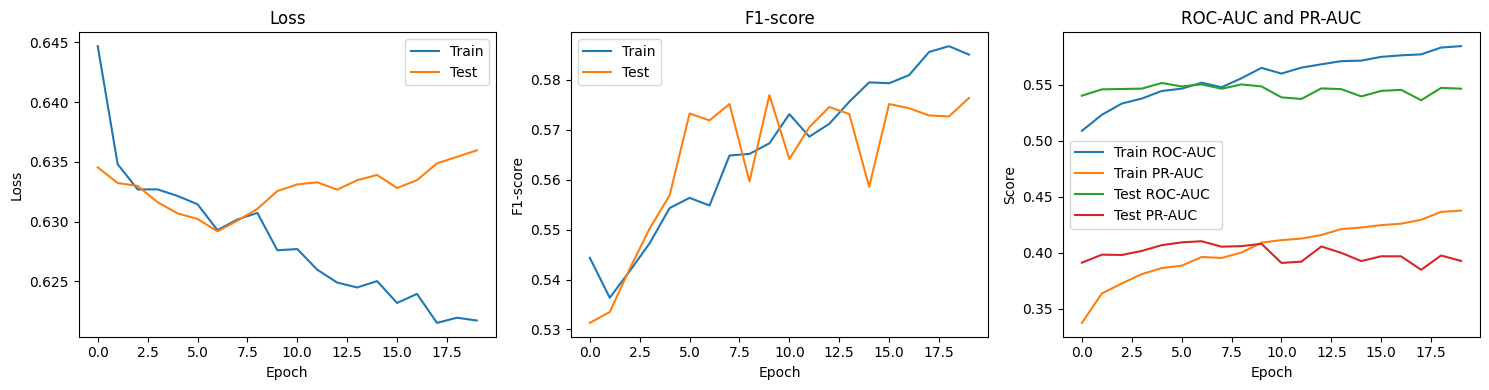

In [31]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)


dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_2490/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_2490/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6438, Train F1-score: 0.5337, Train ROC-AUC: 0.5066, Train PR-AUC: 0.3348, Test Loss: 0.6340, Test F1-score: 0.5313, Test ROC-AUC: 0.5351, Test PR-AUC: 0.3930
Epoch [2/30], Train Loss: 0.6354, Train F1-score: 0.5338, Train ROC-AUC: 0.5295, Train PR-AUC: 0.3615, Test Loss: 0.6350, Test F1-score: 0.5313, Test ROC-AUC: 0.5479, Test PR-AUC: 0.4038
Epoch [3/30], Train Loss: 0.6340, Train F1-score: 0.5361, Train ROC-AUC: 0.5371, Train PR-AUC: 0.3686, Test Loss: 0.6322, Test F1-score: 0.5357, Test ROC-AUC: 0.5472, Test PR-AUC: 0.3990
Epoch [4/30], Train Loss: 0.6337, Train F1-score: 0.5369, Train ROC-AUC: 0.5298, Train PR-AUC: 0.3681, Test Loss: 0.6318, Test F1-score: 0.5395, Test ROC-AUC: 0.5486, Test PR-AUC: 0.4028
Epoch [5/30], Train Loss: 0.6341, Train F1-score: 0.5385, Train ROC-AUC: 0.5341, Train PR-AUC: 0.3698, Test Loss: 0.6310, Test F1-score: 0.5417, Test ROC-AUC: 0.5561, Test PR-AUC: 0.4050
Epoch [6/30], Train Loss: 0.6357, Train F1-score: 0.5416, Train R

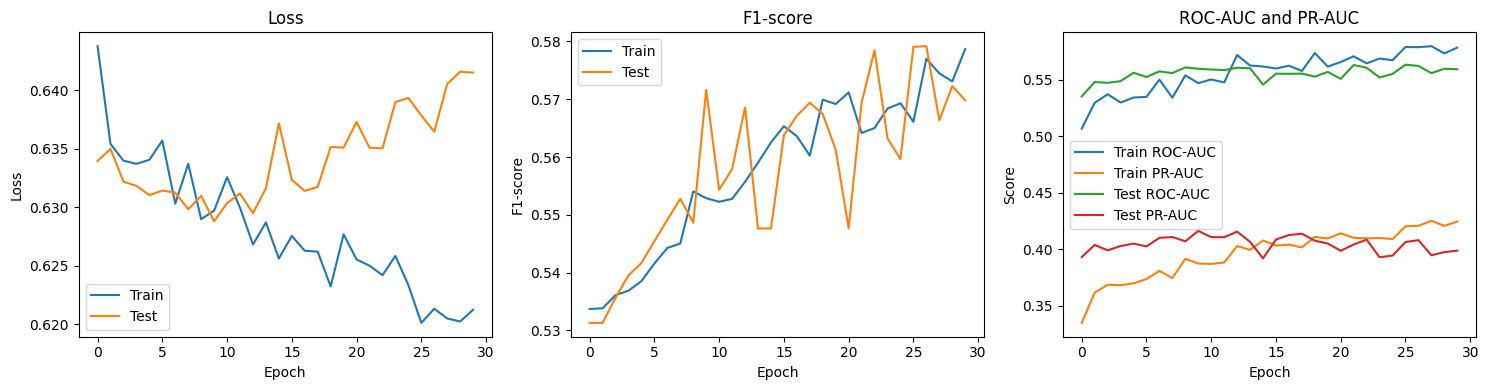

In [33]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

/tmp/ipykernel_2490/140274637.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_2490/140274637.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 75.92it/s]


Epoch [1/20], Train Loss: 0.6417, Train F1-score: 0.5374, Train ROC-AUC: 0.5093, Train PR-AUC: 0.3418, Test Loss: 0.6398, Test F1-score: 0.5313, Test ROC-AUC: 0.5162, Test PR-AUC: 0.3587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.50it/s]


Epoch [2/20], Train Loss: 0.6369, Train F1-score: 0.5355, Train ROC-AUC: 0.5190, Train PR-AUC: 0.3517, Test Loss: 0.6409, Test F1-score: 0.5313, Test ROC-AUC: 0.5553, Test PR-AUC: 0.4064


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.31it/s]


Epoch [3/20], Train Loss: 0.6349, Train F1-score: 0.5371, Train ROC-AUC: 0.5291, Train PR-AUC: 0.3622, Test Loss: 0.6331, Test F1-score: 0.5313, Test ROC-AUC: 0.5398, Test PR-AUC: 0.3917


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.59it/s]


Epoch [4/20], Train Loss: 0.6346, Train F1-score: 0.5391, Train ROC-AUC: 0.5306, Train PR-AUC: 0.3637, Test Loss: 0.6314, Test F1-score: 0.5357, Test ROC-AUC: 0.5547, Test PR-AUC: 0.3987


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.54it/s]


Epoch [5/20], Train Loss: 0.6354, Train F1-score: 0.5416, Train ROC-AUC: 0.5335, Train PR-AUC: 0.3735, Test Loss: 0.6311, Test F1-score: 0.5433, Test ROC-AUC: 0.5626, Test PR-AUC: 0.4036


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.03it/s]


Epoch [6/20], Train Loss: 0.6334, Train F1-score: 0.5507, Train ROC-AUC: 0.5363, Train PR-AUC: 0.3737, Test Loss: 0.6321, Test F1-score: 0.5454, Test ROC-AUC: 0.5572, Test PR-AUC: 0.3960


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.63it/s]


Epoch [7/20], Train Loss: 0.6325, Train F1-score: 0.5489, Train ROC-AUC: 0.5347, Train PR-AUC: 0.3765, Test Loss: 0.6306, Test F1-score: 0.5492, Test ROC-AUC: 0.5496, Test PR-AUC: 0.4066


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.15it/s]


Epoch [8/20], Train Loss: 0.6342, Train F1-score: 0.5488, Train ROC-AUC: 0.5288, Train PR-AUC: 0.3738, Test Loss: 0.6276, Test F1-score: 0.5574, Test ROC-AUC: 0.5645, Test PR-AUC: 0.4161


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.94it/s]


Epoch [9/20], Train Loss: 0.6309, Train F1-score: 0.5515, Train ROC-AUC: 0.5527, Train PR-AUC: 0.3834, Test Loss: 0.6316, Test F1-score: 0.5481, Test ROC-AUC: 0.5456, Test PR-AUC: 0.3871


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.29it/s]


Epoch [10/20], Train Loss: 0.6336, Train F1-score: 0.5493, Train ROC-AUC: 0.5385, Train PR-AUC: 0.3797, Test Loss: 0.6324, Test F1-score: 0.5507, Test ROC-AUC: 0.5566, Test PR-AUC: 0.4090


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.60it/s]


Epoch [11/20], Train Loss: 0.6294, Train F1-score: 0.5542, Train ROC-AUC: 0.5533, Train PR-AUC: 0.3920, Test Loss: 0.6300, Test F1-score: 0.5433, Test ROC-AUC: 0.5622, Test PR-AUC: 0.4152


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.41it/s]


Epoch [12/20], Train Loss: 0.6309, Train F1-score: 0.5593, Train ROC-AUC: 0.5645, Train PR-AUC: 0.3933, Test Loss: 0.6314, Test F1-score: 0.5459, Test ROC-AUC: 0.5659, Test PR-AUC: 0.4123


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.67it/s]


Epoch [13/20], Train Loss: 0.6279, Train F1-score: 0.5532, Train ROC-AUC: 0.5534, Train PR-AUC: 0.3942, Test Loss: 0.6329, Test F1-score: 0.5691, Test ROC-AUC: 0.5562, Test PR-AUC: 0.4119


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.58it/s]


Epoch [14/20], Train Loss: 0.6278, Train F1-score: 0.5542, Train ROC-AUC: 0.5619, Train PR-AUC: 0.3975, Test Loss: 0.6281, Test F1-score: 0.5669, Test ROC-AUC: 0.5651, Test PR-AUC: 0.4160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.48it/s]


Epoch [15/20], Train Loss: 0.6288, Train F1-score: 0.5571, Train ROC-AUC: 0.5565, Train PR-AUC: 0.3973, Test Loss: 0.6305, Test F1-score: 0.5647, Test ROC-AUC: 0.5642, Test PR-AUC: 0.4132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.27it/s]


Epoch [16/20], Train Loss: 0.6268, Train F1-score: 0.5602, Train ROC-AUC: 0.5669, Train PR-AUC: 0.4043, Test Loss: 0.6297, Test F1-score: 0.5669, Test ROC-AUC: 0.5684, Test PR-AUC: 0.4182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.03it/s]


Epoch [17/20], Train Loss: 0.6255, Train F1-score: 0.5533, Train ROC-AUC: 0.5692, Train PR-AUC: 0.4021, Test Loss: 0.6298, Test F1-score: 0.5548, Test ROC-AUC: 0.5737, Test PR-AUC: 0.4189


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.72it/s]


Epoch [18/20], Train Loss: 0.6261, Train F1-score: 0.5550, Train ROC-AUC: 0.5628, Train PR-AUC: 0.3996, Test Loss: 0.6324, Test F1-score: 0.5502, Test ROC-AUC: 0.5702, Test PR-AUC: 0.4110


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.20it/s]


Epoch [19/20], Train Loss: 0.6252, Train F1-score: 0.5586, Train ROC-AUC: 0.5725, Train PR-AUC: 0.4106, Test Loss: 0.6313, Test F1-score: 0.5619, Test ROC-AUC: 0.5689, Test PR-AUC: 0.4128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.00it/s]

Epoch [20/20], Train Loss: 0.6228, Train F1-score: 0.5568, Train ROC-AUC: 0.5751, Train PR-AUC: 0.4108, Test Loss: 0.6347, Test F1-score: 0.5533, Test ROC-AUC: 0.5665, Test PR-AUC: 0.4113


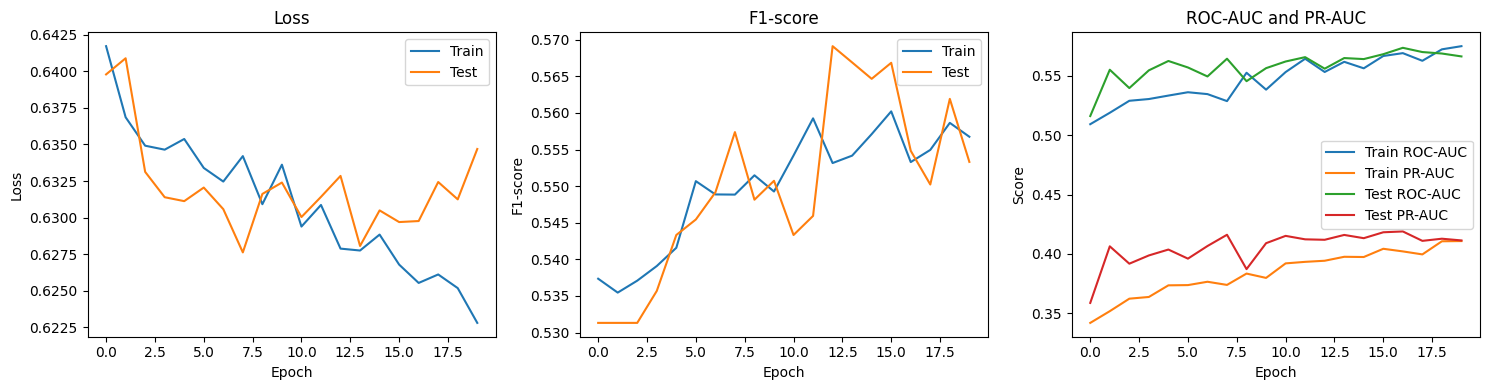

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


input_size = X.shape[1]
hidden_size = 128
output_size = 2


model = MLP(input_size, hidden_size, output_size)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))
    
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)
        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)
        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.6987, Train F1-score: 0.5438, Train ROC-AUC: 0.4831, Train PR-AUC: 0.3239, Test Loss: 0.7021, Test F1-score: 0.5441, Test ROC-AUC: 0.4922, Test PR-AUC: 0.3451
Epoch [2/50], Train Loss: 0.6905, Train F1-score: 0.5700, Train ROC-AUC: 0.4837, Train PR-AUC: 0.3246, Test Loss: 0.6943, Test F1-score: 0.5558, Test ROC-AUC: 0.4941, Test PR-AUC: 0.3472
Epoch [3/50], Train Loss: 0.6829, Train F1-score: 0.5689, Train ROC-AUC: 0.4847, Train PR-AUC: 0.3263, Test Loss: 0.6871, Test F1-score: 0.5581, Test ROC-AUC: 0.4956, Test PR-AUC: 0.3503
Epoch [4/50], Train Loss: 0.6761, Train F1-score: 0.5576, Train ROC-AUC: 0.4861, Train PR-AUC: 0.3274, Test Loss: 0.6805, Test F1-score: 0.5537, Test ROC-AUC: 0.4966, Test PR-AUC: 0.3517
Epoch [5/50], Train Loss: 0.6699, Train F1-score: 0.5508, Train ROC-AUC: 0.4884, Train PR-AUC: 0.3289, Test Loss: 0.6746, Test F1-score: 0.5391, Test ROC-AUC: 0.4988, Test PR-AUC: 0.3529
Epoch [6/50], Train Loss: 0.6644, Train F1-score: 0.5476, Train R

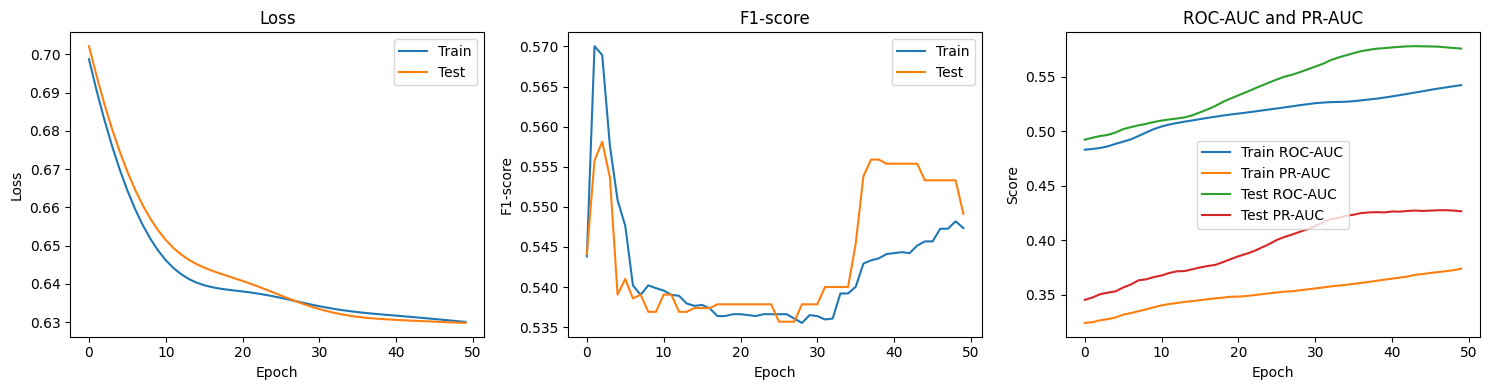

In [37]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [38]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [39]:
df_x

,Histone_CENPA,Histone_H1.2,Histone_H1.5,Histone_H2AK119Ub,Histone_H2AK120Ub,Histone_H2A.X,Histone_H2A.XS139ph,Histone_H2A.Zac,Histone_H2A.Z,Histone_H2BK20ac,...,Histone_H3K14ac,Histone_H3K14cr,Histone_H3K18ac,Histone_H3K23ac,Histone_H3K27me1,Histone_H3K27me2,Histone_H3K28ac,Histone_H3K29ac,Histone_H3,Histone_H3K27me3
0,-0.054106,-0.097447,-0.070829,-0.272855,-0.026264,-0.08095,-0.040373,-0.473968,-0.331614,-0.338339,...,-0.293144,-0.069734,-0.500330,-0.102045,-0.131484,-0.015665,-0.379381,-0.233389,-0.429168,0.387389
1,-0.054106,-0.097447,-0.070829,-0.510575,-0.026264,-0.08095,-0.040373,-0.333975,-0.206489,-0.338339,...,-0.293144,-0.069734,-0.530442,-0.102045,-0.131484,-0.015665,-0.379381,-0.233389,-0.840574,-1.318141
2,-0.054106,-0.097447,-0.070829,-0.510575,-0.026264,-0.08095,-0.040373,-0.473968,-0.609277,-0.338339,...,-0.293144,-0.069734,-0.530442,-0.102045,-0.131484,-0.015665,-0.379381,-0.233389,-0.848390,-1.549606
3,-0.054106,-0.097447,-0.070829,-0.175253,-0.026264,-0.08095,-0.040373,-0.473968,-0.499002,-0.338339,...,-0.293144,-0.069734,-0.530442,-0.102045,-0.131484,-0.015665,-0.379381,-0.233389,-0.067915,0.039489
4,-0.054106,-0.097447,-0.070829,-0.510575,-0.026264,-0.08095,-0.040373,-0.473968,-0.609277,-0.338339,...,-0.293144,-0.069734,-0.530442,-0.102045,-0.131484,-0.015665,-0.379381,-0.233389,0.237607,0.084449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5278,-0.054106,-0.097447,-0.070829,-0.341344,-0.026264,-0.08095,-0.040373,1.518297,0.945480,-0.338339,...,1.374205,-0.069734,1.127773,-0.102045,-0.023753,-0.015665,1.177374,-0.233389,0.372351,0.336860
5279,-0.054106,-0.097447,-0.070829,-0.510575,-0.026264,-0.08095,-0.040373,-0.473968,-0.583266,-0.049029,...,-0.293144,-0.069734,-0.517646,-0.102045,-0.131484,-0.015665,-0.379381,-0.233389,-0.201740,-0.003729
5280,-0.054106,-0.097447,-0.070829,-0.510575,-0.026264,-0.08095,-0.040373,-0.473968,-0.609277,-0.338339,...,-0.293144,-0.069734,-0.530442,-0.102045,-0.131484,-0.015665,-0.379381,-0.233389,-0.553197,-0.184321
5281,-0.054106,-0.097447,-0.070829,-0.510575,-0.026264,-0.08095,-0.040373,-0.473968,-0.359891,-0.338339,...,-0.293144,-0.069734,-0.530442,-0.102045,-0.131484,-0.015665,-0.379381,-0.233389,-1.175219,0.697483


In [40]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [41]:
df_y

,target
0,1
1,0
2,0
3,1
4,1
...,...
5278,0
5279,0
5280,0
5281,0


In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_
for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_2490/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_CENPA: 0.0005146945532941251
Histone_H1.2: 0.020669455397444438
Histone_H1.5: 0.01395985067288245
Histone_H2AK119Ub: 0.06482811966762285
Histone_H2AK120Ub: 0.00018810037076184795
Histone_H2A.X: 0.008508774287012265
Histone_H2A.XS139ph: 0.0023635336592902354
Histone_H2A.Zac: 0.05917602036847667
Histone_H2A.Z: 0.10661587951331356
Histone_H2BK20ac: 0.036246718241892885
Histone_H2Bub: 0.011125197063813822
Histone_H2: 0.0033486101325934355
Histone_H3.3: 0.023072952751423712
Histone_H3K122ac: 0.08016120065067156
Histone_H3K14ac: 0.017559746412678715
Histone_H3K14cr: 0.005660978785789245
Histone_H3K18ac: 0.07636500107874962
Histone_H3K23ac: 0.008285166755436751
Histone_H3K27me1: 0.04828509341517232
Histone_H3K27me2: 0.0004478136963913015
Histone_H3K28ac: 0.03295251375159323
Histone_H3K29ac: 0.02118004643197513
Histone_H3: 0.17234416050792836
Histone_H3K27me3: 0.18614037183379137


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_2490/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.2299
ROC-AUC: 0.4958
PR-AUC: 0.3890


                feature  importance
23     Histone_H3K27me3    0.183893
22           Histone_H3    0.172235
8         Histone_H2A.Z    0.107473
13     Histone_H3K122ac    0.079209
16      Histone_H3K18ac    0.076318
3     Histone_H2AK119Ub    0.067148
7       Histone_H2A.Zac    0.061190
18     Histone_H3K27me1    0.045451
9      Histone_H2BK20ac    0.035594
20      Histone_H3K28ac    0.033367
12         Histone_H3.3    0.022095
1          Histone_H1.2    0.021664
14      Histone_H3K14ac    0.018920
21      Histone_H3K29ac    0.018854
2          Histone_H1.5    0.015108
10        Histone_H2Bub    0.010430
17      Histone_H3K23ac    0.009129
5         Histone_H2A.X    0.008889
15      Histone_H3K14cr    0.006205
11           Histone_H2    0.003355
6   Histone_H2A.XS139ph    0.002403
0         Histone_CENPA    0.000452
19     Histone_H3K27me2    0.000446
4     Histone_H2AK120Ub    0.000174


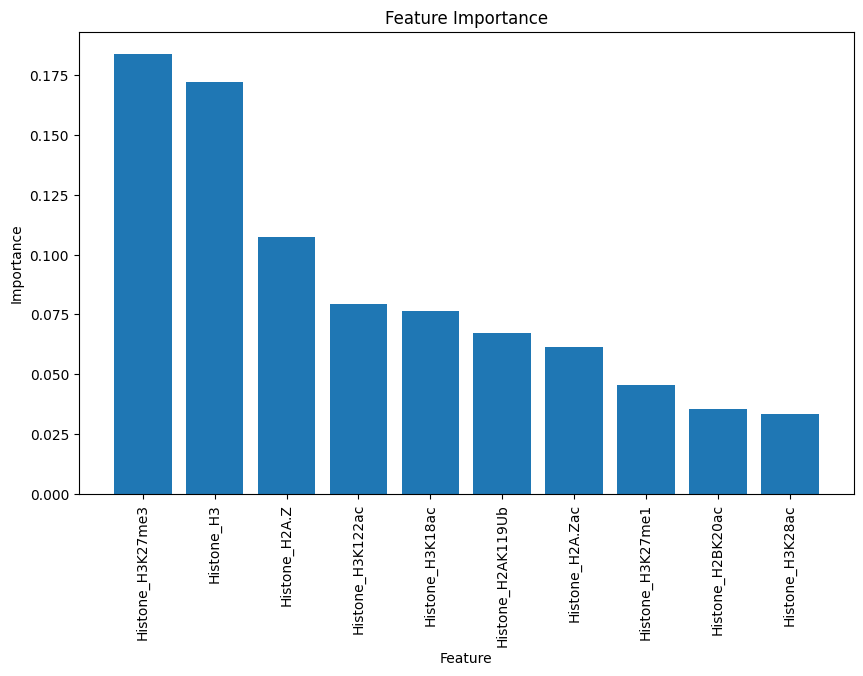

In [44]:
import pandas as pd
import matplotlib.pyplot as plt


importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [45]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6814279	total: 49.9ms	remaining: 49.8s
1:	learn: 0.6718295	total: 51.1ms	remaining: 25.5s
2:	learn: 0.6639848	total: 52.6ms	remaining: 17.5s
3:	learn: 0.6576173	total: 54.1ms	remaining: 13.5s
4:	learn: 0.6523999	total: 55.4ms	remaining: 11s
5:	learn: 0.6479401	total: 56.6ms	remaining: 9.38s
6:	learn: 0.6445215	total: 57.8ms	remaining: 8.2s
7:	learn: 0.6418261	total: 59ms	remaining: 7.32s
8:	learn: 0.6391454	total: 60.3ms	remaining: 6.64s
9:	learn: 0.6369651	total: 61.6ms	remaining: 6.1s
10:	learn: 0.6347951	total: 63ms	remaining: 5.66s
11:	learn: 0.6324109	total: 64.4ms	remaining: 5.3s
12:	learn: 0.6309305	total: 65.6ms	remaining: 4.98s
13:	learn: 0.6298332	total: 67ms	remaining: 4.71s
14:	learn: 0.6286582	total: 68.2ms	remaining: 4.48s
15:	learn: 0.6275808	total: 69.4ms	remaining: 4.27s
16:	learn: 0.6267930	total: 70.6ms	remaining: 4.08s
17:	learn: 0.6250025	total: 71.8ms	remaining: 3.92s
18:	learn: 0.6242647	total: 73ms	remaining: 3.77s
19:	learn: 0.6228891	total: 74.2ms	

164:	learn: 0.5248857	total: 257ms	remaining: 1.3s
165:	learn: 0.5242639	total: 259ms	remaining: 1.3s
166:	learn: 0.5235209	total: 260ms	remaining: 1.3s
167:	learn: 0.5229624	total: 261ms	remaining: 1.29s
168:	learn: 0.5217606	total: 263ms	remaining: 1.29s
169:	learn: 0.5217370	total: 264ms	remaining: 1.29s
170:	learn: 0.5211651	total: 265ms	remaining: 1.28s
171:	learn: 0.5209400	total: 266ms	remaining: 1.28s
172:	learn: 0.5204733	total: 268ms	remaining: 1.28s
173:	learn: 0.5200375	total: 269ms	remaining: 1.27s
174:	learn: 0.5195192	total: 270ms	remaining: 1.27s
175:	learn: 0.5190260	total: 271ms	remaining: 1.27s
176:	learn: 0.5184066	total: 272ms	remaining: 1.27s
177:	learn: 0.5180016	total: 274ms	remaining: 1.26s
178:	learn: 0.5174172	total: 275ms	remaining: 1.26s
179:	learn: 0.5163428	total: 276ms	remaining: 1.26s
180:	learn: 0.5154041	total: 277ms	remaining: 1.25s
181:	learn: 0.5149979	total: 278ms	remaining: 1.25s
182:	learn: 0.5145615	total: 280ms	remaining: 1.25s
183:	learn: 0.5

465:	learn: 0.4072014	total: 638ms	remaining: 731ms
466:	learn: 0.4069608	total: 640ms	remaining: 730ms
467:	learn: 0.4068178	total: 641ms	remaining: 728ms
468:	learn: 0.4065861	total: 642ms	remaining: 727ms
469:	learn: 0.4060893	total: 643ms	remaining: 725ms
470:	learn: 0.4055720	total: 645ms	remaining: 724ms
471:	learn: 0.4053234	total: 646ms	remaining: 722ms
472:	learn: 0.4050219	total: 647ms	remaining: 721ms
473:	learn: 0.4046062	total: 648ms	remaining: 719ms
474:	learn: 0.4044410	total: 650ms	remaining: 718ms
475:	learn: 0.4040038	total: 651ms	remaining: 717ms
476:	learn: 0.4037475	total: 652ms	remaining: 715ms
477:	learn: 0.4036289	total: 654ms	remaining: 714ms
478:	learn: 0.4033839	total: 655ms	remaining: 712ms
479:	learn: 0.4031788	total: 656ms	remaining: 711ms
480:	learn: 0.4029468	total: 657ms	remaining: 709ms
481:	learn: 0.4027384	total: 658ms	remaining: 708ms
482:	learn: 0.4023922	total: 660ms	remaining: 706ms
483:	learn: 0.4023098	total: 661ms	remaining: 704ms
484:	learn: 

630:	learn: 0.3676259	total: 845ms	remaining: 494ms
631:	learn: 0.3674598	total: 846ms	remaining: 493ms
632:	learn: 0.3672595	total: 848ms	remaining: 491ms
633:	learn: 0.3670614	total: 849ms	remaining: 490ms
634:	learn: 0.3667787	total: 850ms	remaining: 489ms
635:	learn: 0.3665216	total: 852ms	remaining: 487ms
636:	learn: 0.3663055	total: 853ms	remaining: 486ms
637:	learn: 0.3661800	total: 854ms	remaining: 485ms
638:	learn: 0.3660513	total: 855ms	remaining: 483ms
639:	learn: 0.3659657	total: 857ms	remaining: 482ms
640:	learn: 0.3657273	total: 858ms	remaining: 480ms
641:	learn: 0.3655569	total: 859ms	remaining: 479ms
642:	learn: 0.3655177	total: 860ms	remaining: 477ms
643:	learn: 0.3652836	total: 861ms	remaining: 476ms
644:	learn: 0.3652226	total: 863ms	remaining: 475ms
645:	learn: 0.3648834	total: 864ms	remaining: 473ms
646:	learn: 0.3647186	total: 865ms	remaining: 472ms
647:	learn: 0.3644867	total: 866ms	remaining: 471ms
648:	learn: 0.3641791	total: 868ms	remaining: 469ms
649:	learn: 

931:	learn: 0.3160597	total: 1.23s	remaining: 89.4ms
932:	learn: 0.3160022	total: 1.23s	remaining: 88.1ms
933:	learn: 0.3158714	total: 1.23s	remaining: 86.8ms
934:	learn: 0.3156837	total: 1.23s	remaining: 85.5ms
935:	learn: 0.3155361	total: 1.23s	remaining: 84.2ms
936:	learn: 0.3154522	total: 1.23s	remaining: 82.9ms
937:	learn: 0.3152646	total: 1.23s	remaining: 81.5ms
938:	learn: 0.3150672	total: 1.24s	remaining: 80.2ms
939:	learn: 0.3148364	total: 1.24s	remaining: 78.9ms
940:	learn: 0.3147569	total: 1.24s	remaining: 77.6ms
941:	learn: 0.3146076	total: 1.24s	remaining: 76.3ms
942:	learn: 0.3143975	total: 1.24s	remaining: 75ms
943:	learn: 0.3142322	total: 1.24s	remaining: 73.6ms
944:	learn: 0.3140874	total: 1.24s	remaining: 72.3ms
945:	learn: 0.3139153	total: 1.24s	remaining: 71ms
946:	learn: 0.3138609	total: 1.25s	remaining: 69.7ms
947:	learn: 0.3137548	total: 1.25s	remaining: 68.4ms
948:	learn: 0.3135985	total: 1.25s	remaining: 67ms
949:	learn: 0.3134253	total: 1.25s	remaining: 65.7ms

In [46]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_CENPA: 0.07985157151276025
Histone_H1.2: 2.239069769234274
Histone_H1.5: 1.7094548845053934
Histone_H2AK119Ub: 8.149653427412545
Histone_H2AK120Ub: 0.035498226987973294
Histone_H2A.X: 0.6484108972253726
Histone_H2A.XS139ph: 0.1471475481615516
Histone_H2A.Zac: 7.039268772849036
Histone_H2A.Z: 10.584616872053541
Histone_H2BK20ac: 4.255544237172851
Histone_H2Bub: 1.0667334767507646
Histone_H2: 0.3172123899210234
Histone_H3.3: 2.3226292944132365
Histone_H3K122ac: 9.031679985388422
Histone_H3K14ac: 1.8414236553539831
Histone_H3K14cr: 0.7609655456985402
Histone_H3K18ac: 8.001485679456321
Histone_H3K23ac: 0.7056707223471446
Histone_H3K27me1: 5.236063731935931
Histone_H3K27me2: 0.025452917999055788
Histone_H3K28ac: 3.2008649209993347
Histone_H3K29ac: 2.2053503084810386
Histone_H3: 15.90604714601204
Histone_H3K27me3: 14.489904018127866


                feature  importance
22           Histone_H3   15.906047
23     Histone_H3K27me3   14.489904
8         Histone_H2A.Z   10.584617
13     Histone_H3K122ac    9.031680
3     Histone_H2AK119Ub    8.149653
16      Histone_H3K18ac    8.001486
7       Histone_H2A.Zac    7.039269
18     Histone_H3K27me1    5.236064
9      Histone_H2BK20ac    4.255544
20      Histone_H3K28ac    3.200865
12         Histone_H3.3    2.322629
1          Histone_H1.2    2.239070
21      Histone_H3K29ac    2.205350
14      Histone_H3K14ac    1.841424
2          Histone_H1.5    1.709455
10        Histone_H2Bub    1.066733
15      Histone_H3K14cr    0.760966
17      Histone_H3K23ac    0.705671
5         Histone_H2A.X    0.648411
11           Histone_H2    0.317212
6   Histone_H2A.XS139ph    0.147148
0         Histone_CENPA    0.079852
4     Histone_H2AK120Ub    0.035498
19     Histone_H3K27me2    0.025453


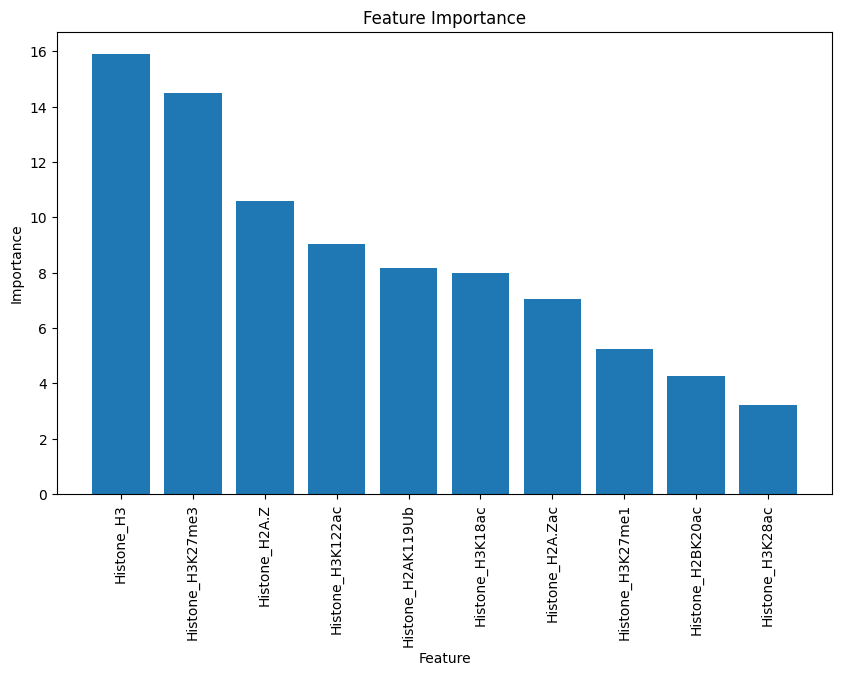

In [47]:

importances = feature_importances

df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
